In [1]:
!pip install mmcv-full

     |████████████████████████████████| 309 kB 4.2 MB/s 
     |████████████████████████████████| 185 kB 44.0 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.12-cp37-cp37m-linux_x86_64.whl size=29278491 sha256=e72c158359b8524f8762b447b7c18f373e0037b7354887e7b00399de0deab1ac
  Stored in directory: /root/.cache/pip/wheels/3a/a4/e1/61968a1aca1a84435171a4162f9a80872951c7b7ff0662ac87
Successfully built mmcv-full


In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

In [2]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2021-09-03 06:13:40--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  5.45MB/s    in 1.2s    

2021-09-03 06:13:42 (5.45 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



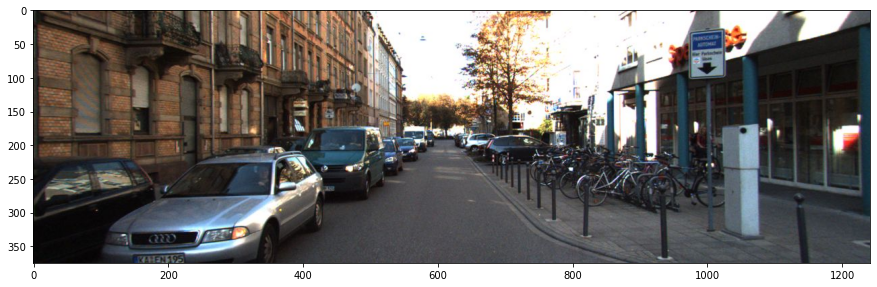

In [3]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

In [4]:
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


In [ ]:
3+5

8

### mmdetection의 중립 annotation 포맷 변환. 해당 포맷은 텍스트로 변환하지 않음. 바로 메모리 상의 list로 생성됨.  
#### filename, width, height, ann을 Key로 가지는 Dictionary를 이미지 개수대로 가지는 list 생성. 
* filename: 이미지 파일명(디렉토리는 포함하지 않음)
* width: 이미지 너비
* height: 이미지 높이
* ann: bbounding box와 label에 대한 정보를 가지는 Dictionary
 - bboxes: 하나의 이미지에 있는 여러 Object 들의 numpy array. 4개의 좌표값(좌상단, 우하단)을 가지고, 해당 이미지에 n개의 Object들이 있을 경우 array의 shape는 (n, 4)
 - labels: 하나의 이미지에 있는 여러 Object들의 numpy array. shape는 (n, )
 - bboxes_ignore: 학습에 사용되지 않고 무시하는 bboxes. 무시하는 bboxes의 개수가 k개이면 shape는 (k, 4)
 - labels_ignore: 학습에 사용되지 않고 무시하는 labels. 무시하는 bboxes의 개수가 k개이면 shape는 (k,)



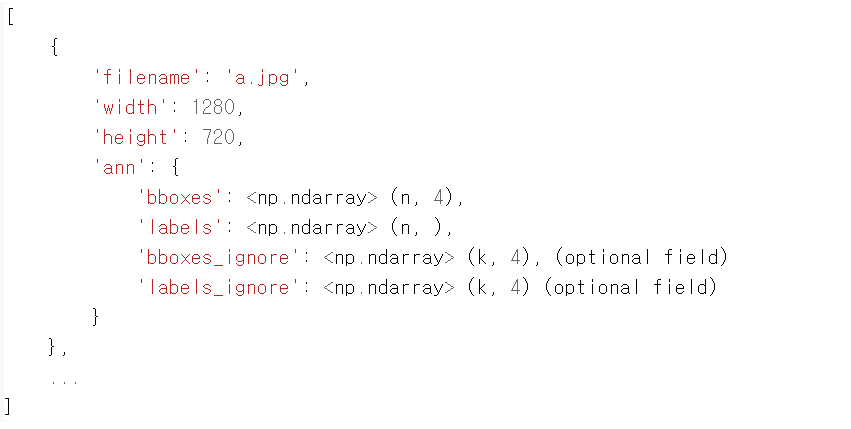

In [5]:
import os
import cv2
import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# decorator
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
    # 반드시 첫 줄에 사용할 CLASSES 지정(CLASSES명은 약속)
    CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')

    # self.ann_file = train.txt
    # self.data_root = /content/kitti_tiny/
    # self.img_prefix = /content/kitti_tiny/training/image_2
    def load_annotations(self, ann_file):
        dict_label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
        #최종 Dataset 담을 그릇
        data_infos = []

        for image_id in image_list:
            # width, height를 구하기 위해 image 경로 생성
            filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
            image = cv2.imread(filename)
            height, width = image.shape[:2]

            data_info = {'filename':str(image_id)+'.jpeg', 'width':width, 'height':height}

            # label.txt에서 정보를 읽기
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(os.path.join(label_prefix, str(image_id)+'.txt'))
            # txt에서 data processing
            content = [line.strip().split(' ') for line in lines]
            bboxes_names = [name[0] for name in content]
            bboxes = [ [float(info) for info in x[4:8]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            for bbox_name, bbox in zip(bboxes_names, bboxes):
                if bbox_name in dict_label:
                    gt_bboxes.append(bbox)
                    gt_labels.append(dict_label[bbox_name])
                else:
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)

            data_anno = {
                'bboxes' : np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                'labels' : np.array(gt_labels, dtype=np.long),
                'bboxes_ignore' : np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                'labels_ignore' : np.array(gt_labels_ignore, dtype=np.long)
            }

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [6]:
### Config 설정하고 Pretrained 모델 다운로드
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [7]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-09-03 06:14:12--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  8.76MB/s    in 19s     

2021-09-03 06:14:32 (8.52 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [8]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)


model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [9]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'traning/image_2'

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.lr_config.policy = 'step'

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [10]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]


/usr/local/lib/python3.7/dist-packages/mmdet-2.16.0-py3.7.egg/mmdet/datasets/custom.py:157: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [11]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [12]:
datasets[0].CLASSES

('Car', 'Truck', 'Pedestrian', 'Cyclist')

In [13]:
model = build_detector(cfg.model, train_cfg= cfg.get('train_cfg'), test_cfg= cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

/usr/local/lib/python3.7/dist-packages/mmdet-2.16.0-py3.7.egg/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [14]:
%cd mmdetection 

mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

/content/mmdetection


In [15]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-09-03 06:15:08,309 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2021-09-03 06:15:08,311 - mmdet - INFO - Use load_from_local loader
2021-09-03 06:15:08,450 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2021-09-03 06:15:08,452 - mmdet - INFO - Start

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 4.0 task/s, elapsed: 6s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-09-03 06:20:30,184 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 154  | 0.968  | 0.861 |
| Truck      | 3   | 22   | 1.000  | 0.600 |
| Pedestrian | 13  | 54   | 0.846  | 0.674 |
| Cyclist    | 7   | 50   | 0.571  | 0.186 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.580 |
+------------+-----+------+--------+-------+
2021-09-03 06:20:30,188 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5800, mAP: 0.5803


/usr/local/lib/python3.7/dist-packages/mmdet-2.16.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.16.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


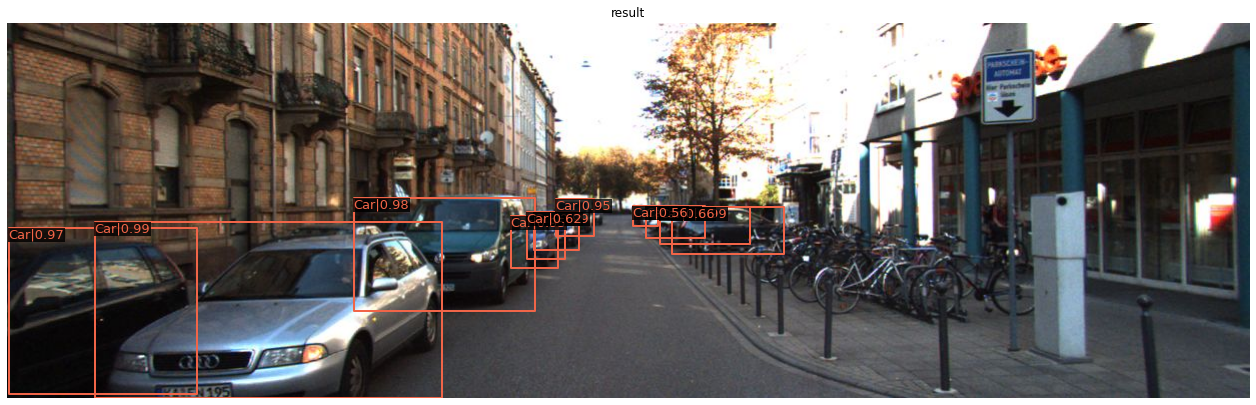

In [19]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/usr/local/lib/python3.7/dist-packages/mmdet-2.16.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.16.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


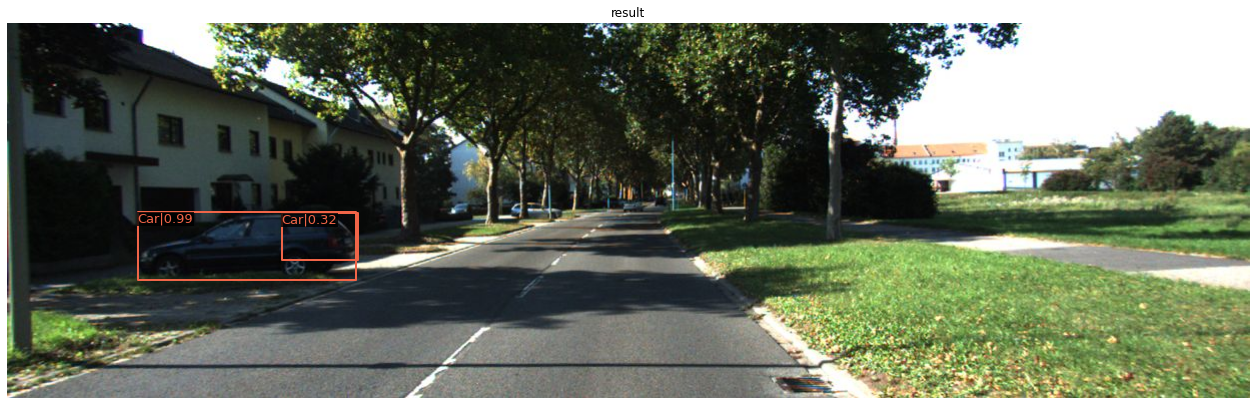

In [17]:
img = cv2.imread('/content/kitti_tiny/training/image_2/000069.jpeg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [24]:
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

/content
--2021-09-03 06:43:15--  https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4 [following]
--2021-09-03 06:43:16--  https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4 [following]
--2021-09-03 06:43:16--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [18]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
label_to_name_seq = {i:k for i, k in enumerate(CLASSES)}
label_to_name_seq

{0: 'Car', 1: 'Truck', 2: 'Pedestrian', 3: 'Cyclist'}

In [22]:
def get_image_detector(model, image_arr, threshold, is_print=True):
    draw_img = image_arr.copy()
    green_box = (0, 255, 0)
    red_text = (0, 0, 255)

    results = inference_detector(model, image_arr)

    for result_idx, result in results:
        if len(result) == 0:
            continue
        
        result_filtered = result[np.where(result[:,4] > threshold)]

        for i in range(len(result_filtered)):
            left = int(result_filtered[i, 0])
            top = int(result_filtered[i, 1])
            right = int(result_filtered[i, 2])
            bottom = int(result_filtered[i, 3])
            score = result_filtered[i, 4]
            caption = '{}:{:.4f}'.format(label_to_name_seq[result_idx], score)

            cv2.rectangle(draw_img, (left, top), (right, bottom), color=green_box, thickness=2)
            cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_text, 1)

            if is_print:
                print(caption)
    return draw_img

In [29]:
import time
def do_detector_video(model, input_path, output_path, threshold, is_print=True):
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    video_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    video_writer = cv2.VideoWriter(output_path, codec, video_fps, video_size)

    frame_cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    print('총 frame 수:', frame_cnt)

    start = time.time()
    while True:
        hasFrame, img_frame = cap.read()

        if hasFrame:
            print('더 이상 출력할 frame이 없습니다.')
            break
        
        img_frame = get_image_detector(model, img_frame, threshold=threshold, is_print=True)

        if is_print:
            pritn('수행시간 :{:.2f}'.format(time.time() - start))
        video_writer.write(img_frame)
    video_writer.release()
    cap.release()


In [30]:
input_path = '/content/data/the_rock_chase.mp4'
output_path = '/content/data/the_rock_chase_out1.mp4'
do_detector_video(model, input_path, output_path, threshold=0.5, is_print=True)

총 frame 수: 503.0
더 이상 출력할 frame이 없습니다.


In [26]:
3+5

8